In [2]:
# IMAGE CONFIGURATIONS
IMAGE_SIZE = [224, 224]

# TRAINING CONFIGURATIONS
epochs = 3
batch_size = 128

## Preparing Data

In [3]:
import pandas as pd
df_train_data = pd.read_csv('../data/merged_train.csv')
df_train_data

,image_id,labels
0,723977410.jpg,3
1,3193577634.jpg,1
2,3349107107.jpg,3
3,2933959901.jpg,0
4,3020460837.jpg,4
...,...,...
27048,1778392170.jpg,2
27049,2495608764.jpg,3
27050,698646619.jpg,4
27051,297559984.jpg,3


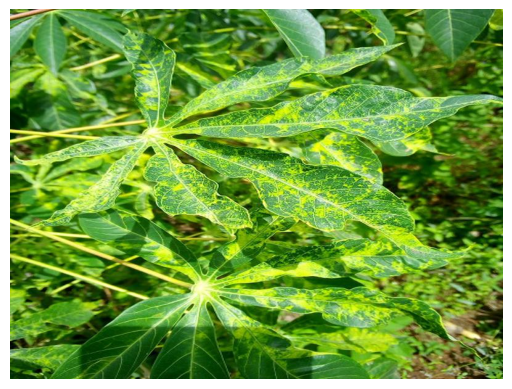

In [4]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from torchvision import transforms

# Define the path to your train_images directory
train_path = "../data/train_images/"

# Use glob to get all image files with .jpg or .jpeg extensions
image_files = glob(train_path + '/*.jp*g')

# Define the transformation (ToTensor)
transform = transforms.ToTensor()

# Randomly select an image path
img_path = np.random.choice(image_files)

# Open the image
image = Image.open(img_path)

# Apply the transform to convert the image to a tensor
image_tensor = transform(image)

# Display the image
plt.imshow(image_tensor.permute(1, 2, 0))  # Permute is needed to change the shape to (H, W, C)
plt.axis('off')  # Hide axis
plt.show()

In [5]:
unique_labels = df_train_data.labels.value_counts()
num_unique_labels = unique_labels.nunique()


In [6]:
from sklearn import model_selection
df_train, df_valid = model_selection.train_test_split(df_train_data, test_size=0.1, random_state=109, stratify=df_train_data["labels"].values)
df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

In [7]:
from torch.utils.data import Dataset
import os
import cv2
class ConstDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['labels'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = os.path.join(train_path, file_name)
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
proc_resize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size = IMAGE_SIZE)
        ])
train_df = ConstDataset(df_train, transform=proc_resize)

In [9]:
import torch
trainloader = torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0)

In [10]:
from tqdm import tqdm
def calc_mean_std(train_df, trainloader):
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    for input_image,_ in tqdm(trainloader):
        psum    += input_image.sum(axis        = [0, 2, 3])
        psum_sq += (input_image ** 2).sum(axis = [0, 2, 3])

    count = len(train_df) * IMAGE_SIZE[0] * IMAGE_SIZE[1]
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    mean = total_mean.numpy()
    std = total_std.numpy()
    return (mean, std)
calc_mean, calc_std = calc_mean_std(train_df, trainloader)

100%|██████████| 191/191 [03:19<00:00,  1.04s/it]


In [11]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=calc_mean, std=calc_std)
])

val_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.Normalize(mean=calc_mean, std=calc_std),
    ]
)

train_df = ConstDataset(df_train, transform=train_transforms)
valid_df = ConstDataset(df_valid, transform=val_transforms)

In [12]:
# trainloader = torch.utils.data.DataLoader(train_df, batch_size=4,
#                                           shuffle=True, num_workers=0)
# torch.manual_seed(124)
# for batch_idx, data in enumerate(trainloader,0):
#     if(batch_idx==0):
#         input, label = data
#         print(type(input))
#         print(input[0].shape)
#         print(input[0])
#         plt.imshow(input[0].numpy().transpose(1,2,0))
#     break;



In [13]:
dataloader = {'train': torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0),
              'val': torch.utils.data.DataLoader(valid_df, batch_size,
                                          shuffle=True, num_workers=0)}

## Training model

In [14]:
# !pip install torch torchvision
# !pip install transformers datasets
# !pip install transformers[torch]

In [15]:
import torch.nn as nn
import torch.optim as optim
from transformers import ViTForImageClassification, TrainingArguments

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
model_name = "google/vit-base-patch16-224"
num_classes = num_unique_labels

model = ViTForImageClassification.from_pretrained(
    model_name, num_labels=num_classes, ignore_mismatched_sizes=True
)
print(model.classifier)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=5, bias=True)


In [17]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [25]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [26]:
!pip show accelerate

Name: accelerate
Version: 0.34.2
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /home/samic_yongjian/miniconda3/lib/python3.11/site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [27]:
from transformers import Trainer
from torch.optim import AdamW
from bi_tempered_loss import bi_tempered_logistic_loss

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Get input images and labels
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Custom loss function (BiTemperedLoss with label smoothing)
        criterion = bi_tempered_logistic_loss(t1=0.8, t2=1.4, smoothing=0.06)
        loss = criterion(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

    def create_optimizer(self):
        # If the optimizer is already created, return it
        if self.optimizer is None:
            # Create AdamW optimizer
            optimizer = AdamW(self.model.parameters(), lr=self.args.learning_rate, weight_decay=self.args.weight_decay)
            self.optimizer = optimizer
        return self.optimizer


In [28]:
# Training arguments configuration
args = TrainingArguments(
    output_dir="../output/model",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01, 
    load_best_model_at_end=True, 
    metric_for_best_model="accuracy",  
    logging_dir="../output/logs", 
    remove_unused_columns=False,
)


# Collate function for combining samples into batches
def collate_fn(examples):
    images = torch.stack([example[0] for example in examples])  # Stack images
    labels = torch.tensor([example[1] for example in examples])  # Stack labels
    return {"pixel_values": images, "labels": labels}


# Metric computation (accuracy)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy_score(labels, predictions)}


# Initialize the trainer
trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=train_df,
    eval_dataset=valid_df,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

In [29]:
%load_ext tensorboard
%tensorboard --logdir ../output/logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 785001), started 0:47:18 ago. (Use '!kill 785001' to kill it.)

In [30]:
trainer.train()

OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/parallel/parallel_apply.py", line 84, in _worker
    output = module(*input, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/transformers/models/vit/modeling_vit.py", line 831, in forward
    outputs = self.vit(
              ^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/transformers/models/vit/modeling_vit.py", line 614, in forward
    encoder_outputs = self.encoder(
                      ^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/transformers/models/vit/modeling_vit.py", line 443, in forward
    layer_outputs = layer_module(hidden_states, layer_head_mask, output_attentions)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/transformers/models/vit/modeling_vit.py", line 404, in forward
    layer_output = self.output(layer_output, hidden_states)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/transformers/models/vit/modeling_vit.py", line 355, in forward
    hidden_states = self.dense(hidden_states)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/modules/linear.py", line 117, in forward
    return F.linear(input, self.weight, self.bias)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 74.00 MiB. GPU 0 has a total capacity of 22.17 GiB of which 9.25 MiB is free. Process 780111 has 2.64 GiB memory in use. Process 787950 has 16.34 GiB memory in use. Including non-PyTorch memory, this process has 2.91 GiB memory in use. Of the allocated memory 2.45 GiB is allocated by PyTorch, and 88.23 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


In [46]:
outputs = trainer.predict(valid_df)
print(outputs.metrics)

/home/samic_yongjian/miniconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.5120325684547424, 'test_accuracy': 0.8189209164818921, 'test_runtime': 25.2443, 'test_samples_per_second': 107.192, 'test_steps_per_second': 0.238}


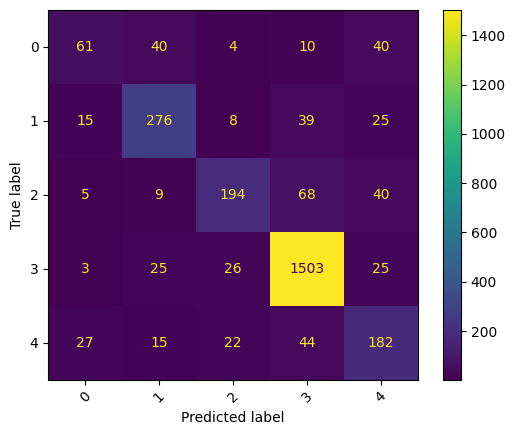

In [47]:
y_true = outputs.label_ids
y_pred = np.argmax(outputs.predictions, axis=1)

labels = np.unique(train_df.labels)
cm = confusion_matrix(y_true, y_pred, labels = labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)